<a href="https://colab.research.google.com/github/d4nye1/flight_on_time_mvp_H12-25-L-Equipo33/blob/feature%2Fdata-science/data-science/DataScience_Modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gdown -q

In [2]:
!pip install lazypredict -q

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
import gdown

## **Selección y entrenamiento de Modelo**

Se alojó la base de datos limpia proveniente del notebook anterior (DataScience - Limpieza y EDA de datos) en un archivo parquet en drive. La misma base se lee para su uso en este notebook.

In [4]:
url = 'https://drive.google.com/file/d/1uCFvcPHO-bchVYWDDtfc7R1Lzr1rSGCI/view?usp=sharing'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]

output = 'df_clean_modeling.parquet'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1uCFvcPHO-bchVYWDDtfc7R1Lzr1rSGCI
To: /content/df_clean_modeling.parquet
100%|██████████| 54.3M/54.3M [00:00<00:00, 98.3MB/s]


'df_clean_modeling.parquet'

In [5]:
cleaned_database = pd.read_parquet("df_clean_modeling.parquet")

In [6]:
cleaned_database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965266 entries, 0 to 6965265
Data columns (total 14 columns):
 #   Column              Dtype  
---  ------              -----  
 0   mes                 int64  
 1   dia_mes             int64  
 2   dia_semana          int64  
 3   fin_de_semana       int64  
 4   hora_salida         int64  
 5   minuto_salida       int64  
 6   distancia_millas    float64
 7   tiempo_programado   float64
 8   aerolinea           object 
 9   aeropuerto_origen   object 
 10  aeropuerto_destino  object 
 11  estado_origen       object 
 12  estado_destino      object 
 13  vuelo_retrasado     int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 744.0+ MB


Se codificaron las variables temporales para reflejar el carácter temporal de las mismas y evitar saltos bruscos entre ellas o pérdida de dicha temporalidad al realizar la codificación de las features.

In [7]:
def encode_cycle(data, col):

    max = data[col].max()
    data[col + '_sin'] = np.sin( 2 * np.pi * data[col] / max)
    data[col + '_cos'] = np.cos( 2 * np.pi * data[col] / max)

    return data

In [8]:
cyclical_columns = ['mes', 'dia_mes', 'dia_semana', 'hora_salida', 'minuto_salida']

for column in cyclical_columns:
  df_clean_modelo = encode_cycle(cleaned_database, column)

Ejemplificación del resultado de la codificación temporal

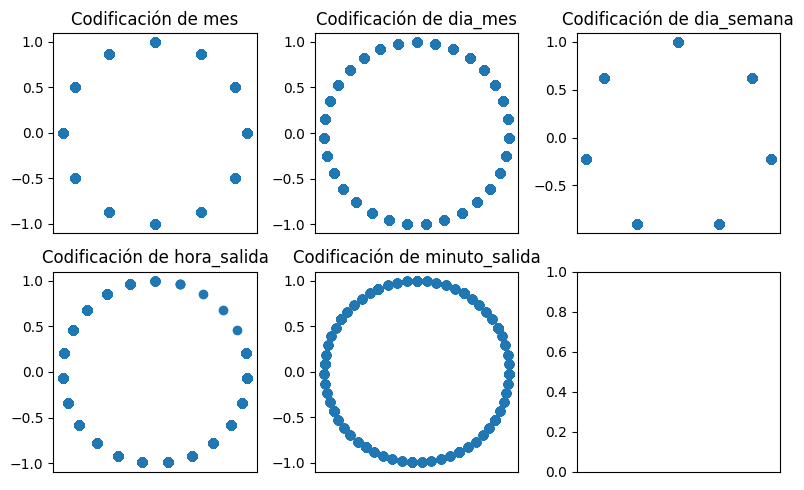

In [9]:
fig, axs = plt.subplots(2, 3, figsize = (8,5) )
sample = cleaned_database.sample(5000, random_state=7)

for i, ax in enumerate(axs.flatten()):
  if( i < len(cyclical_columns)):
    ax.scatter(sample[cyclical_columns[i] + '_sin'], sample[cyclical_columns[i] + '_cos'])
    ax.set_title(f"Codificación de {cyclical_columns[i]}")
  ax.set_xticks([])

plt.tight_layout()
plt.show()

In [10]:
columns_time = ['mes','dia_mes','dia_semana','hora_salida', 'minuto_salida']

for column in columns_time:
  try:
    cleaned_database.drop(columns = column, inplace = True)
  except:
    pass

Se realiza el conteo de valores únicos de las variables categóricas presentes con la finalidad de definir una estrategia de codificación viable. Por la cantidad de categorías, se decide que la codificación One Hot no es viable y se opta ya sea por label encoding, ordinal encoding o target encoding.

In [11]:
categorical_columns = ['aerolinea', 'aeropuerto_origen', 'estado_origen', 'aeropuerto_destino', 'estado_destino']

print("Valores únicos de columnas categóricas")
for column in categorical_columns:
  print(f"{column}: {cleaned_database[column].nunique()}")

Valores únicos de columnas categóricas
aerolinea: 15
aeropuerto_origen: 348
estado_origen: 52
aeropuerto_destino: 348
estado_destino: 52


La mezcla de distintas variables categoricas para producir resultados únicos como categorías previo a codificar tampoco es viable por el tamaño de datos únicos.

In [12]:
cleaned_database['aeropuerto origen-destino'] = cleaned_database['aeropuerto_origen'] + cleaned_database['aeropuerto_destino']
cleaned_database['aeropuerto origen-destino'].nunique()

6792

In [13]:
cleaned_database['estado origen-destino'] = cleaned_database['estado_origen'] + cleaned_database['estado_destino']
cleaned_database['estado origen-destino'].nunique()

1376

### **Resumen de sección**.

#### Cantidad de categorías en

aerolínea : 15

aeropuerto de origen (AO) : 348

aeropuerto de destino (AD) : 348

estado de origen (SO) : 52

estado de destino (SD) : 52

AO + AD : 6792 posibles combinaciones

SO + SD : 1376 posibles combinaciones

In [14]:
!pip install category_encoders -q

In [15]:
import category_encoders as ce

In [16]:
columns_to_drop = ['aeropuerto origen-destino', 'estado origen-destino']

for column in columns_to_drop:
  try:
    cleaned_database.drop(columns = column, inplace = True)
  except:
    pass

Se recodificó a booleano la variable fin de semana ya que para la estandarización no tiene aplicación dejarla como entero y escalarla más allá de su valor booleano intrínseco.

In [17]:
cleaned_database['fin_de_semana'] = cleaned_database['fin_de_semana'].astype(bool)

In [18]:
cleaned_database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965266 entries, 0 to 6965265
Data columns (total 19 columns):
 #   Column              Dtype  
---  ------              -----  
 0   fin_de_semana       bool   
 1   distancia_millas    float64
 2   tiempo_programado   float64
 3   aerolinea           object 
 4   aeropuerto_origen   object 
 5   aeropuerto_destino  object 
 6   estado_origen       object 
 7   estado_destino      object 
 8   vuelo_retrasado     int64  
 9   mes_sin             float64
 10  mes_cos             float64
 11  dia_mes_sin         float64
 12  dia_mes_cos         float64
 13  dia_semana_sin      float64
 14  dia_semana_cos      float64
 15  hora_salida_sin     float64
 16  hora_salida_cos     float64
 17  minuto_salida_sin   float64
 18  minuto_salida_cos   float64
dtypes: bool(1), float64(12), int64(1), object(5)
memory usage: 963.2+ MB


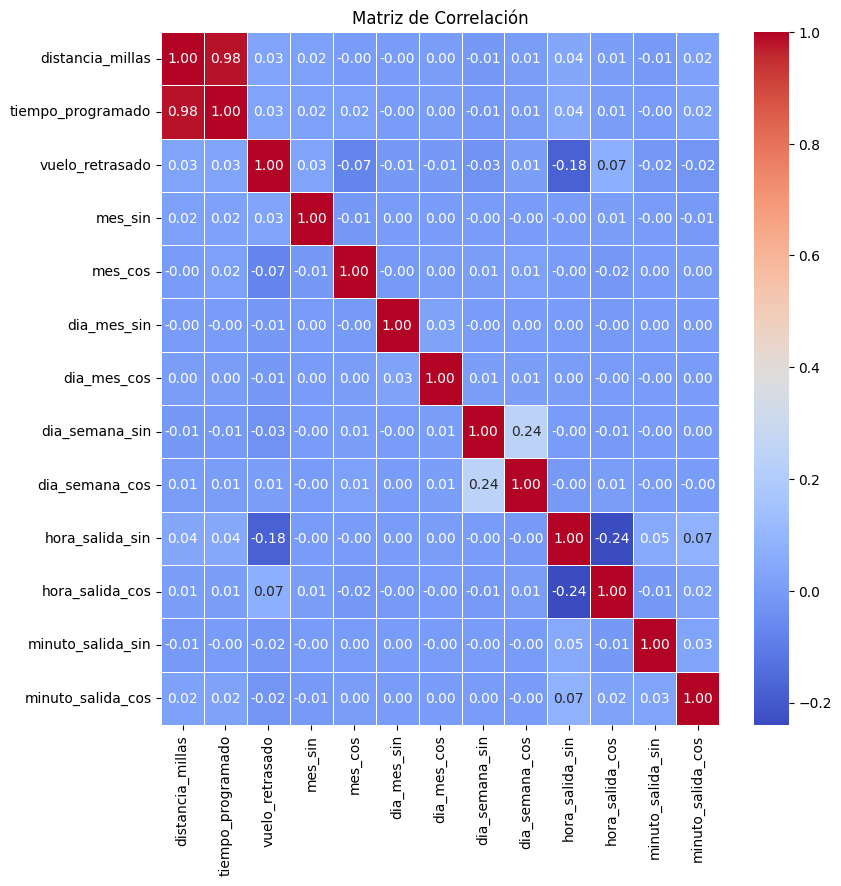

In [19]:
num_cols = cleaned_database.select_dtypes(include=['number']).columns
df_numeric = cleaned_database[num_cols]

matrix = df_numeric.corr(method = 'spearman')

plt.figure(figsize=(9,9))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

De acuerdo con lo encontrado en la matriz de correlación, y en línea con lo encontrado durante el análisis de la base de datos previa, se encuentra que las variables con mayor relación para determinar si un vuelo se retrasa o no son:

1) Hora de salida
2) Mes de vuelo
3) Día de la semana
4) Distancia recorrida y tiempo programado de vuelo

Sin embargo, se hace notar al equipo que por sí mismas, dichas variables se consideran insuficientes para otorgar una predicción de calidad respecto a si un vuelo es retrasado o no, por lo que utilizar muchas de ellas o pocas, no tiene un efecto significativo en la mejora de la predicción.


In [20]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape)-1)))

In [21]:
results = {col: cramers_v(cleaned_database[col], cleaned_database['vuelo_retrasado']) for col in categorical_columns}
results_series = pd.Series(results).sort_values(ascending=False)

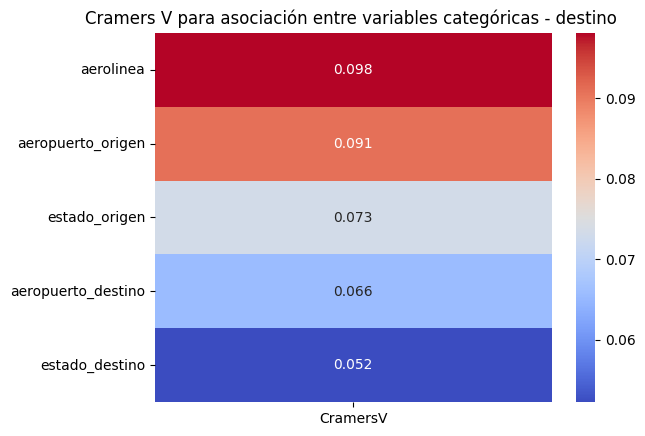

In [22]:
sns.heatmap(pd.DataFrame(results_series, columns=['CramersV']), annot=True, cmap='coolwarm')
plt.title('Cramers V para asociación entre variables categóricas - destino ')
plt.show()

Se calculó la asociación entre las variables mediante la prueba de Cramers V.

En la visualización de las variables categóricas con la variable destino, se observa que las categorías con mayor relación con la etiqueta a predecir son la aerolínea (como se descubrió en el análisis previo de datos), el aeropuerto de origen y el estado de origen.

Nuevamente, se considera que dichas relaciones son relaciones débiles, y por sí solas son de nuevo insuficientes para entrenar un modelo de gran poder predictivo.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

In [24]:
X = cleaned_database.drop(columns = ['vuelo_retrasado', 'minuto_salida_sin', 'minuto_salida_cos', 'dia_mes_sin', 'dia_mes_cos', 'estado_origen',
'estado_destino'])
y = cleaned_database['vuelo_retrasado']

In [25]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = True, random_state= seed)

Para el remuestreo, se utilizó la técnica de Random Under Sampler, la cual toma aleatoriamente muestras del conjunto especificado, particularmente de la clase mayoritaria. Sampling strategy indica la proporción entre clases (clase minoritaria / clase mayoritaria). Se descartó usar una técnica más avanzada como SMOTE para sobremuestreo (SMOTENC para variables categóricas + numéricas) o Near Miss para submuestreo, ya que son técnicas basadas en distancias (vecinos más cercanos) lo que para datos con alta dimensionalidad las vuelve más costosas.

In [48]:
rus = RandomUnderSampler(random_state = seed, sampling_strategy = 1)

In [49]:
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [50]:
print("Antes de submuestreo, 'Retrasado': {}".format(sum(y_train == 1)))
print("Antes de submuestreo, 'A tiempo': {}".format(sum(y_train == 0)))
print()
print("Después de submuestreo, 'Retrasado': {}".format(sum(y_train_rus == 1)))
print("Después de submuestreo, 'A tiempo': {}".format(sum(y_train_rus == 0)))

Antes de submuestreo, 'Retrasado': 973224
Antes de submuestreo, 'A tiempo': 1946448

Después de submuestreo, 'Retrasado': 973224
Después de submuestreo, 'A tiempo': 973224


In [51]:
y_train.value_counts(normalize = True)

,proportion
vuelo_retrasado,
0,0.666667
1,0.333333


In [52]:
y_train_rus.value_counts(normalize=True)

,proportion
vuelo_retrasado,
0,0.5
1,0.5


In [53]:
y_test.value_counts(normalize=True)

,proportion
vuelo_retrasado,
0,0.801079
1,0.198921


In [54]:
X_train = X_train_rus
y_train = y_train_rus

In [55]:
scaler = StandardScaler()
categorical_encoding = OrdinalEncoder()
# model = RandomForestClassifier(n_estimators=10, max_depth = 5, random_state= seed)
# model = LogisticRegression(random_state=seed)
# model = SVC(random_state=seed)
model = XGBClassifier(random_state=seed, max_depth = 7, n_estimators = 200)
# model = AdaBoostClassifier(random_state=seed, n_estimators = 25)

In [56]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X_train.select_dtypes(include=['object']).columns
bool_columns = X_train.select_dtypes(include=['bool']).columns

In [57]:
preprocess = ColumnTransformer(transformers=[
    ('numerical', scaler, numerical_columns.values),
    ('categorical', categorical_encoding, categorical_columns.values),
    ('bool', "passthrough", bool_columns.values)
])

Para el entrenamiento del modelo preliminar se escogió un pequeño pipeline que realiza:
1) Escalado por tipo de variable (categórica, numérica)
2) Entrenamiento del modelo

Para el modelo se visualizan sus métricas (accuracy, y precision, recall y f1-score por clase, así como micro, macro y weighted average), matriz de confusión y curva AUC-ROC. En este punto no se ha realizado selección de hiperparámetros ni validación cruzada, aunque se pretende realizar para asegurar que el modelo sea lo suficientemente robusto. También se realizó la comparación de métricas y gráficos contra un modelo dummy, es decir, un modelo que siempre predice la clase más frecuente.

In [58]:
pipe = Pipeline([
    ('preprocessing', preprocess),
    ('model', model)
])

In [59]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1946448 entries, 2932088 to 6962611
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   fin_de_semana       bool   
 1   distancia_millas    float64
 2   tiempo_programado   float64
 3   aerolinea           object 
 4   aeropuerto_origen   object 
 5   aeropuerto_destino  object 
 6   mes_sin             float64
 7   mes_cos             float64
 8   dia_semana_sin      float64
 9   dia_semana_cos      float64
 10  hora_salida_sin     float64
 11  hora_salida_cos     float64
dtypes: bool(1), float64(8), object(3)
memory usage: 180.1+ MB


In [60]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  array(['distancia_millas', 'tiempo_programado', 'mes_sin', 'mes_cos',
       'dia_semana_sin', 'dia_semana_cos', 'hora_salida_sin',
       'hora_salida_cos'], dtype=object)),
                                                 ('categorical',
                                                  OrdinalEncoder(),
                                                  array(['aerolinea', 'aeropuerto_origen', 'aeropuerto_destino'],
      dtype=obje...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [61]:
y_predicted_train = pipe.predict(X_train)

entrenamiento_reporte = classification_report(y_train, y_predicted_train, output_dict=True)
entrenamiento_reporte_df = pd.DataFrame(entrenamiento_reporte).T

In [62]:
entrenamiento_reporte_df

,precision,recall,f1-score,support
0,0.671477,0.669269,0.670371,9.732240e+05
1,0.670353,0.672557,0.671454,9.732240e+05
accuracy,0.670913,0.670913,0.670913,6.709134e-01
macro avg,0.670915,0.670913,0.670912,1.946448e+06
weighted avg,0.670915,0.670913,0.670912,1.946448e+06


In [63]:
def plot_confusion_matrix(y_true, y_pred, labels, title = 'Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm / cm.sum(axis=1, keepdims=True)
    text = np.array([[f"{count}\n({perc:.1%})" for count, perc in zip(row_c, row_p)]
    for row_c, row_p in zip(cm, cm_percent)])

    # fig = plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=text, fmt='', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Clase predicha', fontweight='bold')
    plt.ylabel('Clase real', fontweight='bold')
    plt.title(title, weight = 'bold')
    # plt.show()

In [64]:
def plot_roc_curve(y_true, y_pred):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)

  # fig = plt.figure(figsize=(5, 5))
  plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.4f}')
  plt.plot([0, 1], [0, 1], color='black', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title('ROC Curve', fontweight='bold')
  plt.legend(loc='lower right')
  plt.grid()
  # plt.show()

In [65]:
categories = ['A tiempo', 'Retrasado']

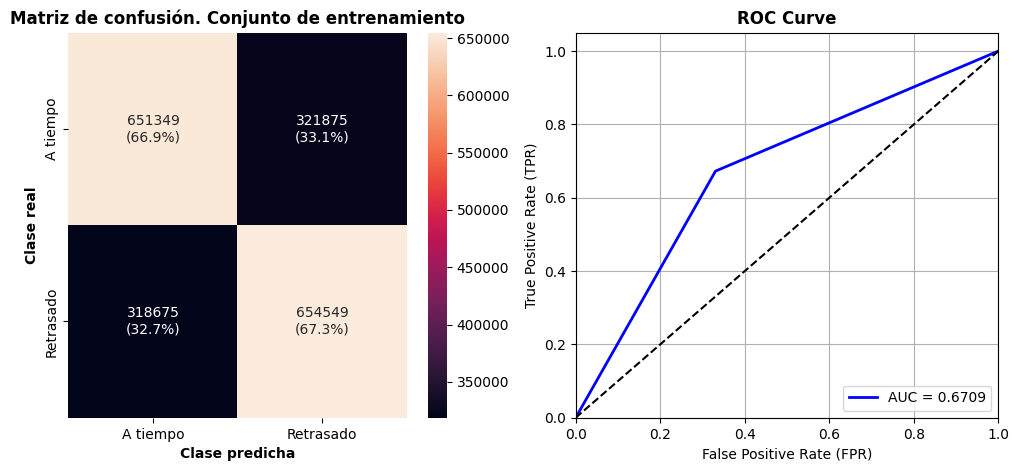

In [66]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plot_confusion_matrix(y_train, y_predicted_train, categories, 'Matriz de confusión. Conjunto de entrenamiento')
plt.subplot(1,2,2)
plot_roc_curve(y_train, y_predicted_train)
plt.show()

In [67]:
y_predicted = pipe.predict(X_test)

testing_reporte = classification_report(y_test, y_predicted, output_dict=True)
testing_reporte_df = pd.DataFrame(testing_reporte).T

In [68]:
testing_reporte_df

,precision,recall,f1-score,support
0,0.885622,0.655253,0.753217,1.673918e+06
1,0.321949,0.659201,0.432613,4.156620e+05
accuracy,0.656039,0.656039,0.656039,6.560385e-01
macro avg,0.603785,0.657227,0.592915,2.089580e+06
weighted avg,0.773495,0.656039,0.689442,2.089580e+06


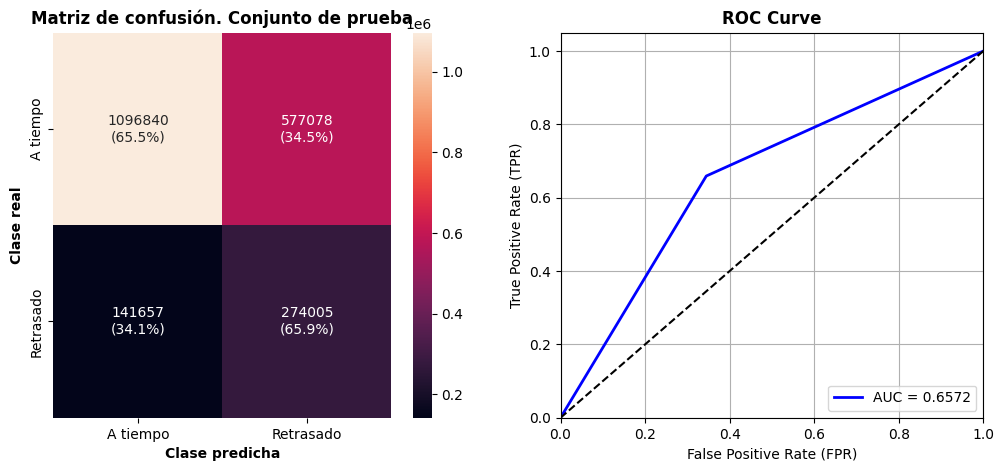

In [69]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plot_confusion_matrix(y_test, y_predicted, categories, 'Matriz de confusión. Conjunto de prueba')
plt.subplot(1,2,2)
plot_roc_curve(y_test, y_predicted)
plt.show()

In [70]:
from sklearn.dummy import DummyClassifier

In [77]:
dummy = DummyClassifier(strategy='prior')
dummy.fit(X_train, y_train)

y_pred_train_dummy = dummy.predict(X_train)
y_pred_dummy = dummy.predict(X_test)

In [79]:
testing_reporte = classification_report(y_test, y_pred_dummy, output_dict=True)
testing_reporte_df_dummy = pd.DataFrame(testing_reporte).T

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [81]:
testing_reporte_df_dummy

,precision,recall,f1-score,support
0,0.801079,1.000000,0.889554,1.673918e+06
1,0.000000,0.000000,0.000000,4.156620e+05
accuracy,0.801079,0.801079,0.801079,8.010787e-01
macro avg,0.400539,0.500000,0.444777,2.089580e+06
weighted avg,0.641727,0.801079,0.712603,2.089580e+06


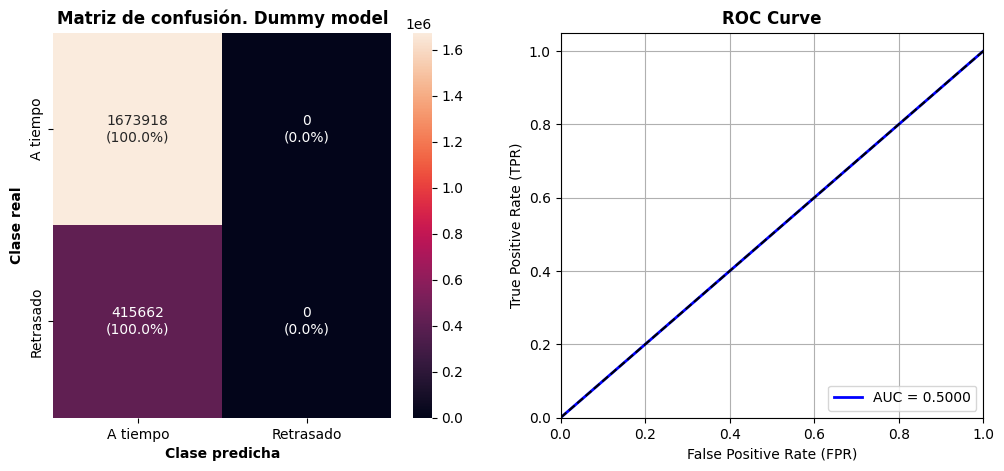

In [78]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plot_confusion_matrix(y_test, y_pred_dummy, categories, 'Matriz de confusión. Dummy model')
plt.subplot(1,2,2)
plot_roc_curve(y_test, y_pred_dummy)
plt.show()